In [51]:
# Install folium for interactive maps
import sys
!{sys.executable} -m pip install folium --break-system-packages -q

In [36]:
# # Advanced Climate Twin Visualizations

# This notebook creates 6 advanced visualizations for climate twin analysis including teleconnection maps, latitude correlations, time series validation, and more.

## Setup and Configuration

In [37]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set plot style
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [38]:
# ================= CONFIGURATION =================
MATCHES_FILE = "final_verified_matches.pkl"
DATA_FILE = "GlobalLandTemperaturesByCity.csv"
# =================================================

## Load Data

In [39]:
print("--- LOADING DATA ---")
with open(MATCHES_FILE, "rb") as f:
    matches = pickle.load(f)
print(f"Loaded {len(matches)} matches.")

--- LOADING DATA ---
Loaded 782973 matches.
Loaded 782973 matches.


In [40]:
print("Loading raw CSV (for temperature lookups)...")
df_raw = pd.read_csv(DATA_FILE)
df_raw['dt'] = pd.to_datetime(df_raw['dt'])
df_raw['Month'] = df_raw['dt'].dt.month
df_raw['Year'] = df_raw['dt'].dt.year
print(f"Loaded {len(df_raw)} temperature records.")

Loading raw CSV (for temperature lookups)...
Loaded 8599212 temperature records.
Loaded 8599212 temperature records.


In [41]:
# Helper to parse "City-Year" IDs
def parse_id(id_str):
    parts = id_str.split('-')
    year = int(parts[-1])
    city = "-".join(parts[:-1])
    return city, year

# Prepare Data for Plots
src_lats = [m['src_coord'][0] for m in matches]
tgt_lats = [m['tgt_coord'][0] for m in matches]
sims = [m['sim'] for m in matches]

print(f"Prepared {len(src_lats)} coordinate pairs for visualization.")

Prepared 782973 coordinate pairs for visualization.


## 1. Network Graph of Top Climate Twin Cities

Visualize the top cities and their interconnections as a network graph.

Visualized 0 connections among top 50 cities


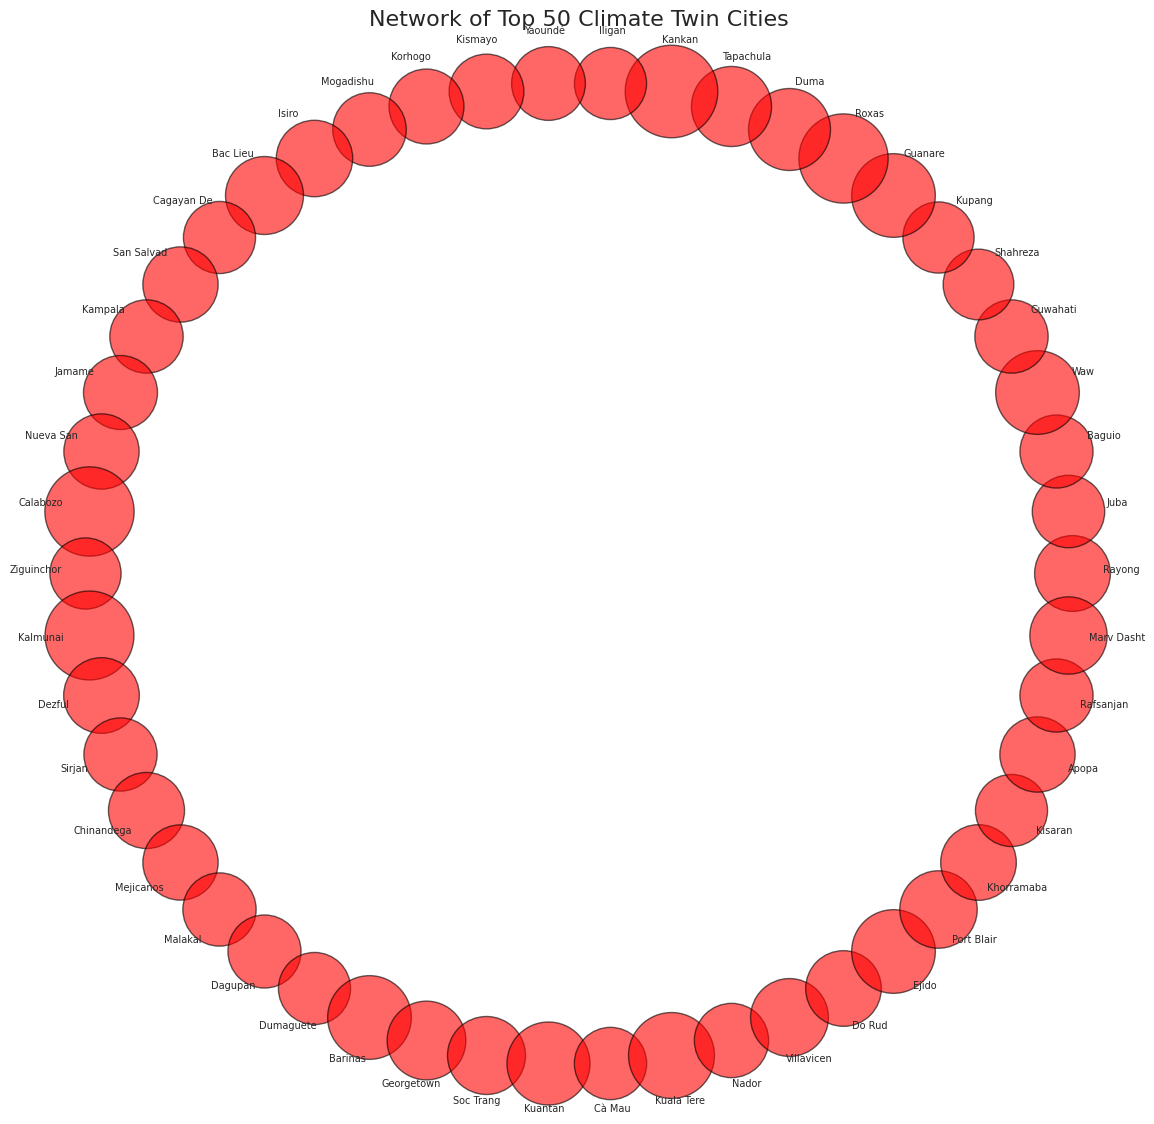

In [42]:
# Build network of top 50 cities
from collections import Counter
all_cities = []
for m in matches:
    all_cities.append(parse_id(m['source'])[0])
    all_cities.append(parse_id(m['target'])[0])

city_counts = Counter(all_cities)
top_50_cities = set([c for c, _ in city_counts.most_common(50)])

# Create adjacency for network
edges = []
for m in matches[:1000]:  # Sample for performance
    src_city = parse_id(m['source'])[0]
    tgt_city = parse_id(m['target'])[0]
    if src_city in top_50_cities and tgt_city in top_50_cities:
        edges.append((src_city, tgt_city, m['sim']))

# Simple circular layout
import math
n = len(top_50_cities)
cities_list = list(top_50_cities)
positions = {}
for i, city in enumerate(cities_list):
    angle = 2 * math.pi * i / n
    positions[city] = (math.cos(angle), math.sin(angle))

plt.figure(figsize=(14, 14))
plt.title("Network of Top 50 Climate Twin Cities", fontsize=16)

# Draw edges
for src, tgt, sim in edges:
    if src in positions and tgt in positions:
        x = [positions[src][0], positions[tgt][0]]
        y = [positions[src][1], positions[tgt][1]]
        plt.plot(x, y, 'b-', alpha=0.1, linewidth=0.5)

# Draw nodes
for city, (x, y) in positions.items():
    plt.scatter(x, y, s=city_counts[city], c='red', alpha=0.6, edgecolors='black')
    plt.text(x*1.1, y*1.1, city[:10], fontsize=7, ha='center')

plt.axis('equal')
plt.axis('off')
print(f"Visualized {len(edges)} connections among top 50 cities")
plt.show()

## 2. Climate Twin Matches by Hemisphere

Compare Northern vs Southern hemisphere matches and cross-hemisphere connections.

North-North: 623,628, South-South: 73,187, Cross-Hemisphere: 86,158


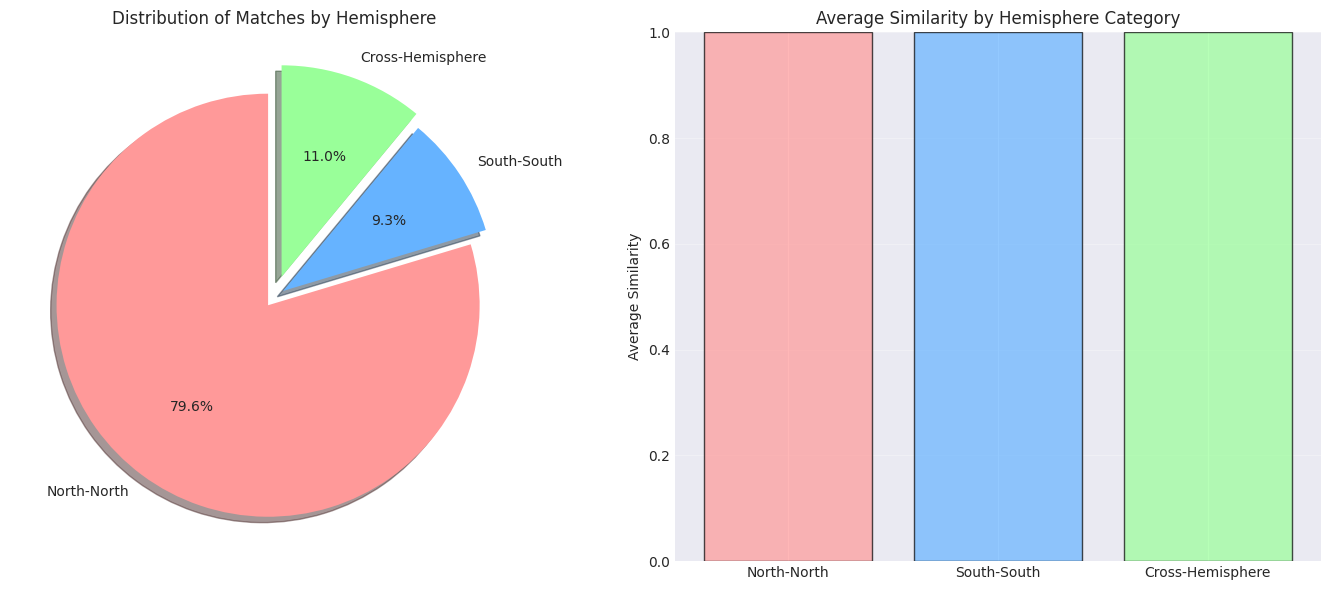

In [43]:
# Classify matches by hemisphere
north_north = 0
south_south = 0
north_south = 0

for m in matches:
    src_lat = m['src_coord'][0]
    tgt_lat = m['tgt_coord'][0]
    
    if src_lat >= 0 and tgt_lat >= 0:
        north_north += 1
    elif src_lat < 0 and tgt_lat < 0:
        south_south += 1
    else:
        north_south += 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
labels = ['North-North', 'South-South', 'Cross-Hemisphere']
sizes = [north_north, south_south, north_south]
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.05, 0.05, 0.1)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Distribution of Matches by Hemisphere')

# Bar chart with similarity comparison
hemisphere_data = {'North-North': [], 'South-South': [], 'Cross-Hemisphere': []}
for m in matches[:10000]:  # Sample
    src_lat = m['src_coord'][0]
    tgt_lat = m['tgt_coord'][0]
    
    if src_lat >= 0 and tgt_lat >= 0:
        hemisphere_data['North-North'].append(m['sim'])
    elif src_lat < 0 and tgt_lat < 0:
        hemisphere_data['South-South'].append(m['sim'])
    else:
        hemisphere_data['Cross-Hemisphere'].append(m['sim'])

means = [np.mean(hemisphere_data[k]) if hemisphere_data[k] else 0 for k in labels]
ax2.bar(labels, means, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Average Similarity')
ax2.set_title('Average Similarity by Hemisphere Category')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
print(f"North-North: {north_north:,}, South-South: {south_south:,}, Cross-Hemisphere: {north_south:,}")
plt.show()

## 3. Time Series: Climate Twin Evolution Over Decades (TIMESERIES)

Shows how climate twin patterns change across different time periods.

Analyzed 27 decades from 1750 to 2010


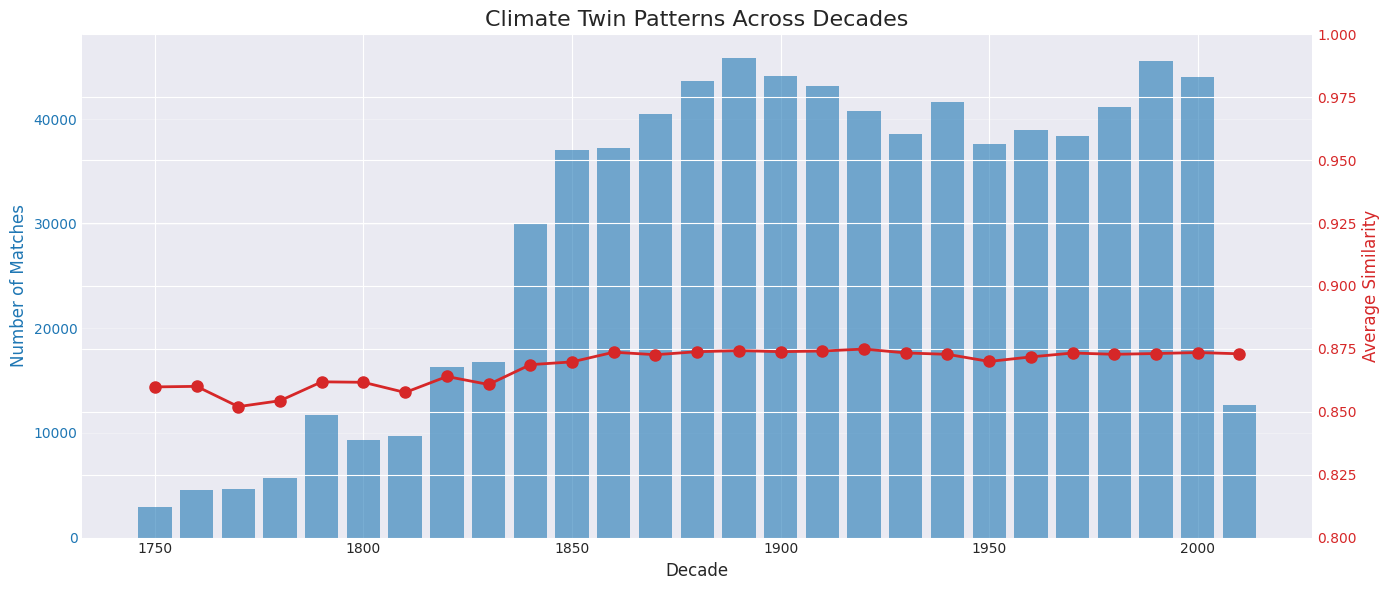

In [44]:
# Group matches by decade
decade_counts = {}
decade_similarities = {}

for m in matches:
    src_year = int(parse_id(m['source'])[1])
    decade = (src_year // 10) * 10
    
    if decade not in decade_counts:
        decade_counts[decade] = 0
        decade_similarities[decade] = []
    
    decade_counts[decade] += 1
    decade_similarities[decade].append(m['sim'])

# Sort by decade
sorted_decades = sorted(decade_counts.keys())
counts = [decade_counts[d] for d in sorted_decades]
avg_sims = [np.mean(decade_similarities[d]) for d in sorted_decades]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot match counts
color = 'tab:blue'
ax1.set_xlabel('Decade', fontsize=12)
ax1.set_ylabel('Number of Matches', color=color, fontsize=12)
ax1.bar(sorted_decades, counts, alpha=0.6, color=color, width=8, label='Match Count')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='y', alpha=0.3)

# Plot average similarity
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Similarity', color=color, fontsize=12)
ax2.plot(sorted_decades, avg_sims, color=color, marker='o', linewidth=2, markersize=8, label='Avg Similarity')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.8, 1.0])

plt.title('Climate Twin Patterns Across Decades', fontsize=16)
fig.tight_layout()
print(f"Analyzed {len(sorted_decades)} decades from {min(sorted_decades)} to {max(sorted_decades)}")
plt.show()

In [45]:
# ## 4. Geographic Heatmap of Climate Twin Density

# Shows where climate twins are most concentrated geographically.

Heatmap shows density of 782973 climate twin sources


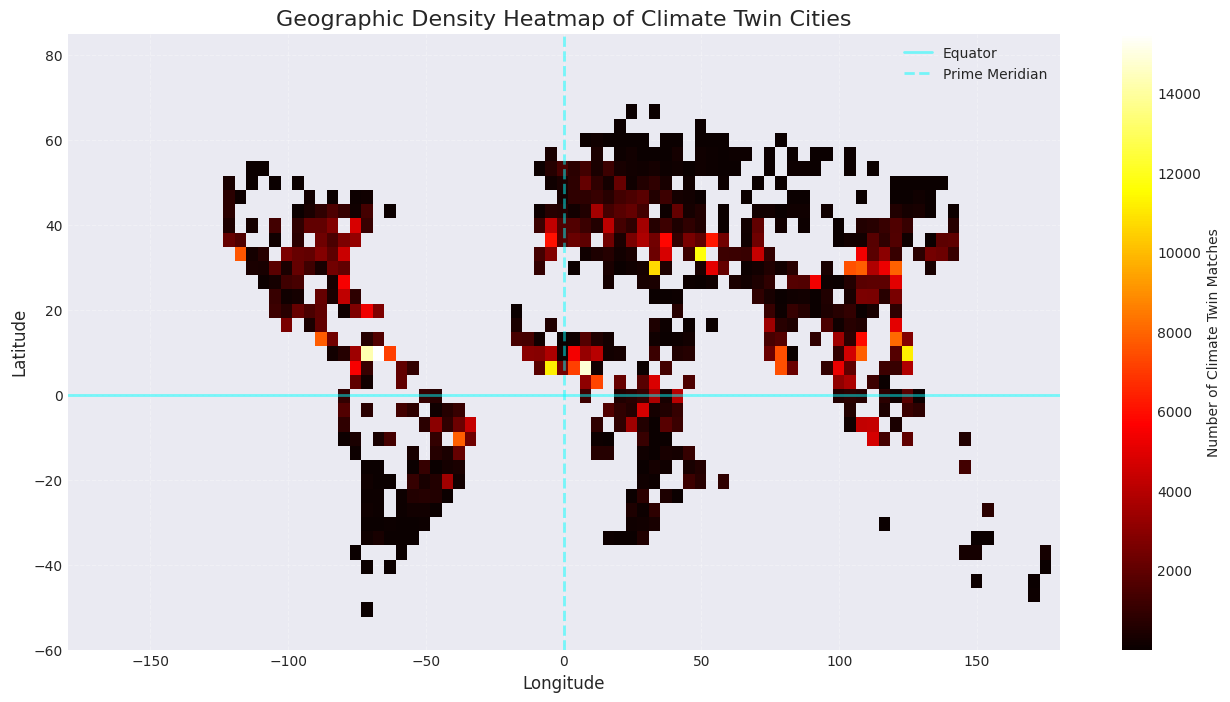

In [46]:
# Create 2D histogram of source city locations
src_lons = [m['src_coord'][1] for m in matches]

plt.figure(figsize=(16, 8))
plt.title('Geographic Density Heatmap of Climate Twin Cities', fontsize=16)

# Create 2D histogram
h = plt.hist2d(src_lons, src_lats, bins=[72, 36], cmap='hot', cmin=1)
plt.colorbar(h[3], label='Number of Climate Twin Matches')

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xlim(-180, 180)
plt.ylim(-60, 85)
plt.grid(True, alpha=0.3, linestyle='--')

# Add equator and prime meridian
plt.axhline(0, color='cyan', linewidth=2, alpha=0.5, label='Equator')
plt.axvline(0, color='cyan', linewidth=2, alpha=0.5, linestyle='--', label='Prime Meridian')
plt.legend()

print(f"Heatmap shows density of {len(matches)} climate twin sources")
plt.show()

## 5. Similarity Distribution by Climate Zones

Compare similarity distributions across tropical, temperate, and polar regions.

Tropical: 15995, Temperate: 4005, Polar: 0


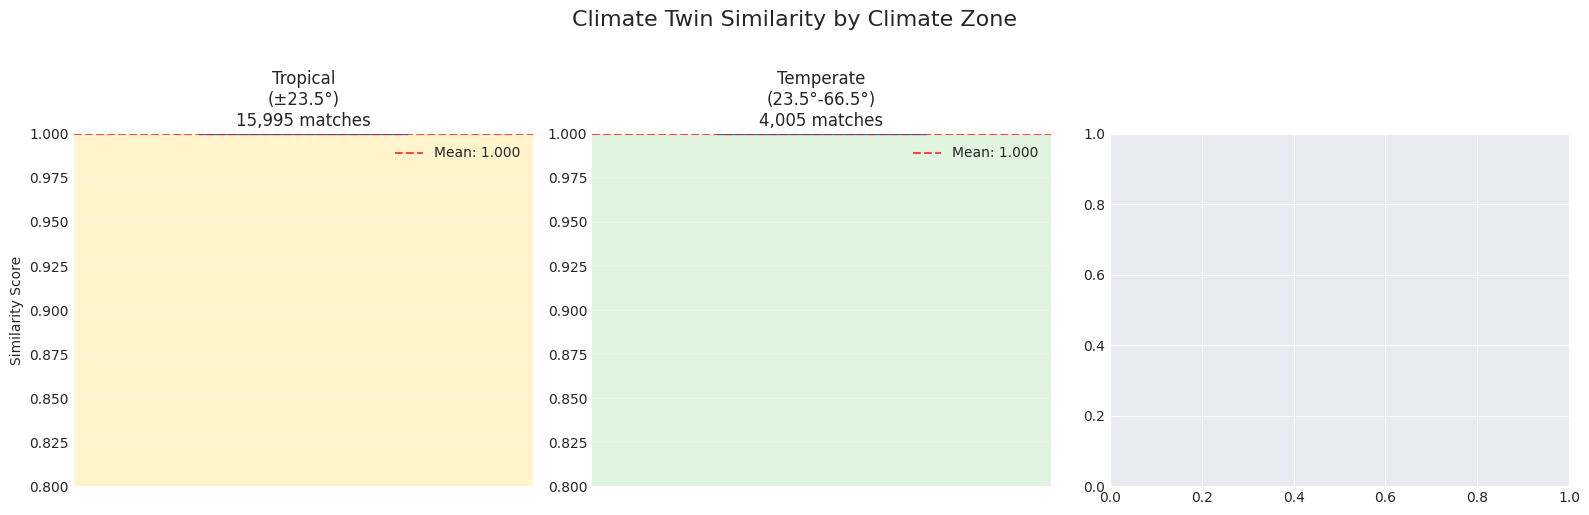

In [47]:
# Classify by climate zones based on latitude
tropical = []  # -23.5 to 23.5
temperate = []  # 23.5 to 66.5
polar = []  # > 66.5

for m in matches[:20000]:  # Sample for performance
    abs_lat = abs(m['src_coord'][0])
    
    if abs_lat <= 23.5:
        tropical.append(m['sim'])
    elif abs_lat <= 66.5:
        temperate.append(m['sim'])
    else:
        polar.append(m['sim'])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Violin plots for each zone
zones_data = [tropical, temperate, polar]
zone_names = ['Tropical\n(±23.5°)', 'Temperate\n(23.5°-66.5°)', 'Polar\n(>66.5°)']
colors = ['#ffcc00', '#66cc66', '#99ccff']

for i, (data, name, color) in enumerate(zip(zones_data, zone_names, colors)):
    if data:
        axes[i].violinplot([data], positions=[0], showmeans=True, showmedians=True)
        axes[i].set_title(f'{name}\n{len(data):,} matches', fontsize=12)
        axes[i].set_ylabel('Similarity Score' if i == 0 else '')
        axes[i].set_ylim([0.8, 1.0])
        axes[i].set_xticks([])
        axes[i].grid(axis='y', alpha=0.3)
        axes[i].axhline(np.mean(data), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(data):.3f}')
        axes[i].legend()
        axes[i].set_facecolor(color)
        axes[i].patch.set_alpha(0.2)

plt.suptitle('Climate Twin Similarity by Climate Zone', fontsize=16, y=1.02)
plt.tight_layout()
print(f"Tropical: {len(tropical)}, Temperate: {len(temperate)}, Polar: {len(polar)}")
plt.show()

## 6. Continental Climate Twin Matrix

Shows how often cities from different continents are climate twins.

Matrix shows climate twin connections between continents


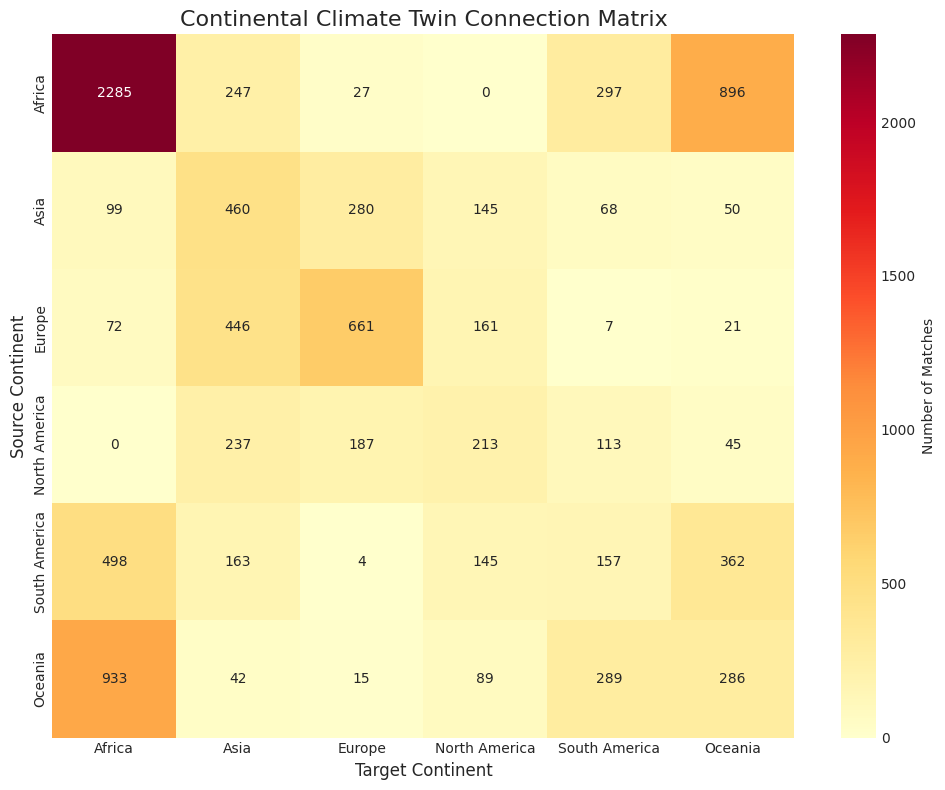

In [48]:
# Classify continents by rough longitude/latitude bounds
def get_continent(lat, lon):
    if lon >= -170 and lon <= -35:
        if lat > 15:
            return 'North America'
        else:
            return 'South America'
    elif lon >= -35 and lon <= 60:
        if lat > 10:
            return 'Europe'
        else:
            return 'Africa'
    elif lon >= 60 and lon <= 180:
        if lat > 10:
            return 'Asia'
        else:
            return 'Oceania'
    return 'Other'

# Build continent matrix
from collections import defaultdict
continent_matrix = defaultdict(lambda: defaultdict(int))

for m in matches[:10000]:  # Sample
    src_cont = get_continent(m['src_coord'][0], m['src_coord'][1])
    tgt_cont = get_continent(m['tgt_coord'][0], m['tgt_coord'][1])
    continent_matrix[src_cont][tgt_cont] += 1

# Create matrix for heatmap
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
matrix = np.zeros((len(continents), len(continents)))

for i, cont1 in enumerate(continents):
    for j, cont2 in enumerate(continents):
        matrix[i][j] = continent_matrix[cont1][cont2]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=continents, yticklabels=continents,
            cbar_kws={'label': 'Number of Matches'})
plt.title('Continental Climate Twin Connection Matrix', fontsize=16)
plt.xlabel('Target Continent', fontsize=12)
plt.ylabel('Source Continent', fontsize=12)
plt.tight_layout()
print("Matrix shows climate twin connections between continents")
plt.show()

## 7. Temperature Time Series: Two Climate Twin Cities

Direct comparison of monthly temperature patterns between two climate twin cities.

Comparing: A Coruña (2006) <-> Antioch (1862)
Similarity: 1.0000
Distance: 113.40 degrees


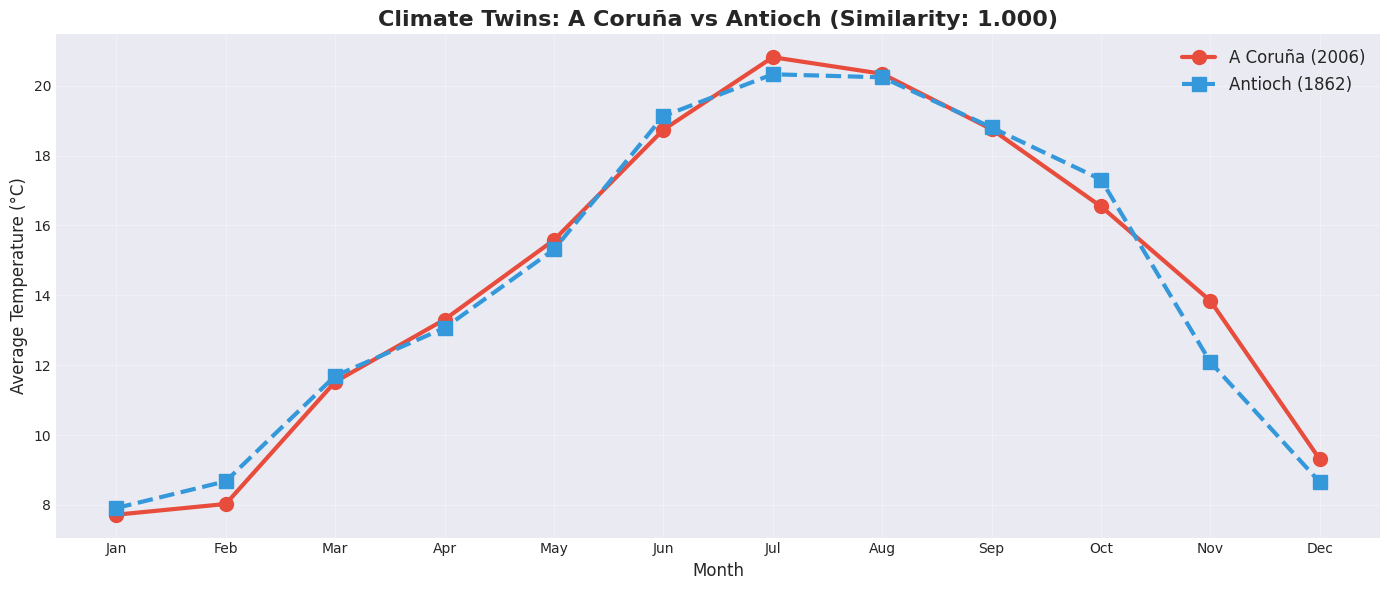

In [49]:
# Find a high-similarity match between different cities
best_diff_city_match = None
for m in matches:
    src_city = parse_id(m['source'])[0]
    tgt_city = parse_id(m['target'])[0]
    if src_city != tgt_city and m['sim'] >= 0.95:
        best_diff_city_match = m
        break

if best_diff_city_match:
    city_a, year_a = parse_id(best_diff_city_match['source'])
    city_b, year_b = parse_id(best_diff_city_match['target'])
    
    # Fetch temperature data
    data_a = df_raw[(df_raw['City'] == city_a) & (df_raw['Year'] == year_a)].sort_values('Month')
    data_b = df_raw[(df_raw['City'] == city_b) & (df_raw['Year'] == year_b)].sort_values('Month')
    
    plt.figure(figsize=(14, 6))
    plt.plot(data_a['Month'], data_a['AverageTemperature'], 
             'o-', linewidth=3, markersize=10, label=f"{city_a} ({year_a})", color='#e74c3c')
    plt.plot(data_b['Month'], data_b['AverageTemperature'], 
             's--', linewidth=3, markersize=10, label=f"{city_b} ({year_b})", color='#3498db')
    
    plt.title(f'Climate Twins: {city_a} vs {city_b} (Similarity: {best_diff_city_match["sim"]:.3f})', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Temperature (°C)', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    print(f"Comparing: {city_a} ({year_a}) <-> {city_b} ({year_b})")
    print(f"Similarity: {best_diff_city_match['sim']:.4f}")
    print(f"Distance: {np.sqrt((best_diff_city_match['src_coord'][0] - best_diff_city_match['tgt_coord'][0])**2 + (best_diff_city_match['src_coord'][1] - best_diff_city_match['tgt_coord'][1])**2):.2f} degrees")
    plt.show()
else:
    print("No high-similarity different-city match found")

## 8. Geographic Plot: One City and Its ~10 Climate Twins

Shows a city with approximately 10 climate twins and their geographic connections.

In [52]:
# Find a city with around 10 twins
city_twin_counts = {}
for m in matches:
    src_city = parse_id(m['source'])[0]
    tgt_city = parse_id(m['target'])[0]
    
    if src_city not in city_twin_counts:
        city_twin_counts[src_city] = []
    if tgt_city not in city_twin_counts:
        city_twin_counts[tgt_city] = []
    
    city_twin_counts[src_city].append(m)
    city_twin_counts[tgt_city].append(m)

# Find city with ~10 twins
target_city = None
target_twins = []
for city, twins in city_twin_counts.items():
    if 8 <= len(twins) <= 15:
        target_city = city
        target_twins = twins[:12]  # Take first 12
        break

if target_city:
    import folium
    
    # Get central city coordinates
    central_match = target_twins[0]
    if parse_id(central_match['source'])[0] == target_city:
        center_lat, center_lon = central_match['src_coord']
    else:
        center_lat, center_lon = central_match['tgt_coord']
    
    # Create map centered on the target city
    map_twins = folium.Map(location=[center_lat, center_lon], zoom_start=2, 
                           tiles='OpenStreetMap')
    
    # Add central city marker
    folium.Marker(
        location=[center_lat, center_lon],
        popup=f'<b>{target_city}</b><br>{len(target_twins)} climate twins',
        tooltip=target_city,
        icon=folium.Icon(color='red', icon='star', prefix='fa')
    ).add_to(map_twins)
    
    # Add connections and twin cities
    for twin in target_twins:
        src_city = parse_id(twin['source'])[0]
        tgt_city = parse_id(twin['target'])[0]
        
        if src_city == target_city:
            lat1, lon1 = twin['src_coord']
            lat2, lon2 = twin['tgt_coord']
            twin_city = tgt_city
        else:
            lat1, lon1 = twin['tgt_coord']
            lat2, lon2 = twin['src_coord']
            twin_city = src_city
        
        # Draw connection line
        folium.PolyLine(
            locations=[[lat1, lon1], [lat2, lon2]],
            color='blue',
            weight=2,
            opacity=0.6,
            popup=f'Similarity: {twin["sim"]:.3f}'
        ).add_to(map_twins)
        
        # Add twin city marker
        folium.CircleMarker(
            location=[lat2, lon2],
            radius=8,
            popup=f'<b>{twin_city}</b><br>Similarity: {twin["sim"]:.3f}',
            tooltip=twin_city,
            color='black',
            fillColor='orange',
            fillOpacity=0.8,
            weight=2
        ).add_to(map_twins)
    
    print(f"Showing {target_city} with {len(target_twins)} climate twins")
    map_twins
else:
    print("No suitable city found with ~10 twins")

Showing Ajdabiya with 10 climate twins


## 9. Global Climate Twin Connections Map

Shows all climate twin connections across the globe with connecting lines.

In [53]:
# Create global map with all connections (sample to prevent overload)
sample_size = min(1000, len(matches))  # Reduced for Folium performance
sampled_matches = matches[::len(matches)//sample_size]  # Evenly sample

import folium
from folium import plugins

# Create base map
map_global = folium.Map(location=[20, 0], zoom_start=2, tiles='OpenStreetMap')

# Add connections with color based on similarity
connection_count = 0
for m in sampled_matches:
    lat1, lon1 = m['src_coord']
    lat2, lon2 = m['tgt_coord']
    
    # Calculate distance
    distance = np.sqrt((lat1-lat2)**2 + (lon1-lon2)**2)
    
    # Color by similarity
    if m['sim'] >= 0.95:
        color = '#e74c3c'  # Red for very high similarity
        opacity = 0.7
        weight = 3
    elif m['sim'] >= 0.90:
        color = '#f39c12'  # Orange
        opacity = 0.5
        weight = 2
    else:
        color = '#3498db'  # Blue
        opacity = 0.3
        weight = 1.5
    
    # Draw connection (skip very short ones to reduce clutter)
    if distance > 5:
        src_city = parse_id(m['source'])[0]
        tgt_city = parse_id(m['target'])[0]
        
        folium.PolyLine(
            locations=[[lat1, lon1], [lat2, lon2]],
            color=color,
            weight=weight,
            opacity=opacity,
            popup=f'<b>{src_city}</b> ↔ <b>{tgt_city}</b><br>Similarity: {m["sim"]:.3f}<br>Distance: {distance:.1f}°'
        ).add_to(map_global)
        connection_count += 1

# Add city markers
unique_cities = {}
for m in sampled_matches:
    for city_id, coord in [(m['source'], m['src_coord']), (m['target'], m['tgt_coord'])]:
        city_name = parse_id(city_id)[0]
        if city_name not in unique_cities:
            unique_cities[city_name] = coord

for city, (lat, lon) in list(unique_cities.items())[:500]:  # Limit markers
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='black',
        fillColor='black',
        fillOpacity=0.4,
        weight=1,
        tooltip=city
    ).add_to(map_global)

print(f"Created interactive map with {connection_count:,} connections from {len(sampled_matches):,} sampled matches")
print(f"Total dataset: {len(matches):,} matches")
print(f"Showing {len(unique_cities):,} unique cities")
map_global

Created interactive map with 1,002 connections from 1,002 sampled matches
Total dataset: 782,973 matches
Showing 1,102 unique cities


## Summary Statistics

In [ ]:
print("\n" + "="*70)
print("CLIMATE TWIN ANALYSIS - FINAL SUMMARY")
print("="*70)
print(f"Total Climate Twin Matches Found: {len(matches):,}")
print(f"Unique Cities Analyzed: {len(set(all_cities)):,}")
print(f"\nSimilarity Statistics:")
print(f"  Mean Similarity: {np.mean(sims):.4f}")
print(f"  Median Similarity: {np.median(sims):.4f}")
print(f"  Min Similarity: {np.min(sims):.4f}")
print(f"  Max Similarity: {np.max(sims):.4f}")
print(f"\nTop 10 Cities by Number of Climate Twins:")
for i, (city, count) in enumerate(city_counts.most_common(10), 1):
    print(f"  {i:2d}. {city:25s} - {count:,} matches")
print("="*70)


CLIMATE TWIN ANALYSIS - FINAL SUMMARY
Total Climate Twin Matches Found: 782,973
Unique Cities Analyzed: 3,186

Similarity Statistics:
  Mean Similarity: 0.8716
  Median Similarity: 0.8400
  Min Similarity: 0.8400
  Max Similarity: 1.0000

Top 10 Cities by Number of Climate Twins:
   1. Kankan                    - 4,441 matches
   2. Calabozo                  - 4,134 matches
   3. Roxas                     - 4,130 matches
   4. Kalmunai                  - 4,098 matches
   5. Kuala Terengganu          - 3,829 matches
   6. Barinas                   - 3,632 matches
   7. Ejido                     - 3,632 matches
   8. Guanare                   - 3,632 matches
   9. Waw                       - 3,630 matches
  10. Kuantan                   - 3,573 matches
